In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image, ImageDraw, ImageChops
import matplotlib.gridspec as gridspec
import os
from tqdm import tqdm

In [12]:
def find_image_size(geojson_data):
    max_width, max_height = 0, 0
    for feature in geojson_data['features']:
        if feature['geometry']['type'] == 'Polygon':
            for point in feature['geometry']['coordinates'][0]:
                max_width = max(max_width, point[0])
                max_height = max(max_height, point[1])
    return 1024, 1024 

# Funktion zur Erstellung einer farbigen Maske aus GeoJSON
def create_colored_mask_from_geojson(geojson_file_path):
    # GeoJSON-Datei laden
    with open(geojson_file_path, 'r') as file:
        geojson_data = json.load(file)
    
    # Bildgröße basierend auf den maximalen Koordinaten bestimmen
    image_size = find_image_size(geojson_data)

    # Erstellen eines leeren Bildes (RGB)
    mask = Image.new('RGB', (image_size[0], image_size[1]), (255, 255, 255))  
    draw = ImageDraw.Draw(mask)

    # Schleife über alle Features in der GeoJSON-Datei
    for feature in geojson_data['features']:
        if feature['geometry']['type'] == 'Polygon':
            # Holen der Polygon-Koordinaten und Umwandeln in ein Tuple für Pillow
            polygon = [(point[0], point[1]) for point in feature['geometry']['coordinates'][0]]
            
            # Holen der Klassifikation
            classification = feature['properties']['classification']
            
            # Farben direkt aus dem GeoJSON holen
            if 'color' in classification:
                color = tuple(map(int, classification['color']))
            else:
                # Falls der 'color'-Schlüssel fehlt, eine Standardfarbe verwenden oder überspringen
                print(f"Warnung: 'color'-Schlüssel fehlt in Klassifikation {classification['name']}")
                color = (255, 255, 255)  # Standardfarbe (z. B. Schwarz)
                # Optional: Überspringe dieses Feature
                # continue

            # Zeichnen des Polygons in der Maske mit der angegebenen Farbe
            draw.polygon(polygon, fill=color)

    return mask

# # Funktion zur Anzeige der Maske
def show_mask(mask):
    plt.imshow(mask)  # Direktes Anzeigen des Pillow-Bildes
    plt.axis('off')
    plt.show()



In [ ]:
// Hole die aktuellen Bilddaten
def imageData = getCurrentImageData()

// Definiere den Ausgabeordner (relativ zum Projekt)
def outputDir = buildFilePath(PROJECT_BASE_DIR, 'export')
mkdirs(outputDir)

// Hole den Bildnamen ohne Dateiendung
def name = GeneralTools.getNameWithoutExtension(imageData.getServer().getMetadata().getName())

// Erstelle den Pfad für die Ausgabe der Label-Bilder
def path = buildFilePath(outputDir, name + "-nuclei-labels.png")

// Definiere den Downsampling-Faktor (wichtig bei großen Bildern)
double downsample = 8

// Erstelle einen ImageServer, bei dem die Pixel aus den Annotationen abgeleitet werden
def labelServer = new LabeledImageServer.Builder(imageData)
  .backgroundLabel(0, ColorTools.WHITE)  // Setze den Hintergrund auf Weiß (Label 0)
  .downsample(downsample)                // Wähle die Downsampling-Rate
  .addLabel('nuclei_tumor', 1)           // Füge die Nuclei-Klassen hinzu
  .addLabel('nuclei_lymphocyte', 2)
  .addLabel('nuclei_stroma', 3)
  .addLabel('nuclei_neutrophil', 4)
  .addLabel('nuclei_endothelium', 5)
  .addLabel('nuclei_melanophage', 6)
  .addLabel('nuclei_plasma_cell', 7)
  .addLabel('nuclei_histiocyte', 8)
  .addLabel('nuclei_apoptosis', 9)
  .addLabel('nuclei_epithelium', 10)
  .multichannelOutput(false)             // Keine Multichannel-Ausgabe
  .build()

// Schreibe das Bild auf den Pfad
writeImage(labelServer, path)

// Bestätige den erfolgreichen Export in der Konsole
println "Nuclei Labels wurden erfolgreich unter dem Pfad " + path + " exportiert."

In [13]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Funktion zur Anzeige von Originalbild, Maske, Overlay und der Legende rechts innerhalb des Plots
def show_image_mask_overlay_with_inline_legend(original_image, mask, overlay, class_colors, figsize=(20, 10)):
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Originalbild anzeigen
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Maske anzeigen
    axes[1].imshow(mask)
    axes[1].set_title("Mask")
    axes[1].axis('off')

    # Overlay anzeigen
    axes[2].imshow(overlay)
    axes[2].set_title("Overlay")
    axes[2].axis('off')

    # Legende hinzufügen
    patches = [mpatches.Patch(color=[c/255 for c in color], label=class_name) for class_name, color in class_colors.items()]
    
    # Legende in den Plot setzen
    plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=12)

    # Anzeige
    plt.tight_layout()
    plt.show()

def load_image(image_path):
    return Image.open(image_path)


def create_overlay(original_image, mask, alpha=0.75):
    """
    Erstellt ein Overlay-Bild, indem eine Maske über ein Originalbild gelegt wird.
    
    Args:
    - original_image (PIL.Image.Image): Das Originalbild.
    - mask (numpy.ndarray): Die Maske als NumPy-Array.
    - alpha (float): Der Alpha-Wert für das Overlay (Transparenz).
    
    Returns:
    - PIL.Image.Image: Das Bild mit der überlagerten Maske.
    """
    # Wandelt die NumPy-Maske in ein PIL-Image um
    mask_image = Image.fromarray(mask.astype('uint8'))
    
    # Das Overlay-Bild hat die gleiche Größe wie das Originalbild
    overlay = ImageChops.add(original_image.convert("RGB"), mask_image, scale=2.0)
    
    # Das Originalbild und das Overlay zusammenmischen
    return Image.blend(original_image.convert("RGB"), overlay, alpha)

### save masks

In [150]:
save_path = "/Volumes/Samsung SSD-Bachelorarbeit/dataset"
pr_met = "primary"

for sample_nr_int in tqdm(range(1, 104)): 
    sammple_nr = f"{sample_nr_int:03d}" 
    base_tissue_path = fr"/Volumes/Samsung SSD-Bachelorarbeit/01_training_dataset_geojson_tissue"
    base_nuclei_path = fr'/Volumes/Samsung SSD-Bachelorarbeit/01_training_dataset_geojson_nuclei'
    base_roi = fr'/Volumes/Samsung SSD-Bachelorarbeit/01_training_dataset_tif_ROIs'



    tissue_file_name = fr"training_set_{pr_met}_roi_{sammple_nr}_tissue.geojson"
    nuclei_file_name = fr"training_set_{pr_met}_roi_{sammple_nr}_nuclei.geojson"

    roi_name = fr'training_set_{pr_met}_roi_{sammple_nr}.tif'

    tissue_file_path = os.path.join(base_tissue_path, tissue_file_name)
    nuclei_file_path = os.path.join(base_nuclei_path, nuclei_file_name)
    image_path = os.path.join(base_roi, roi_name)


    tissue_mask = create_colored_mask_from_geojson(tissue_file_path)
    original_image = load_image(image_path)
    tissue_overlay = create_overlay(original_image, tissue_mask)

    nuclei_mask = create_colored_mask_from_geojson(nuclei_file_path)
    nuclei_overlay = create_overlay(original_image, nuclei_mask)
    

    
    
    base_filename_tissue = os.path.splitext(tissue_file_name)[0]  # Dateiname ohne Endung
    base_filename_nuclei = os.path.splitext(nuclei_file_name)[0]  # Dateiname ohne Endung


    tissue_mask_save_path = os.path.join(save_path, pr_met, "tissue_masks", f"{base_filename_tissue}.png")
    nuclei_mask_save_path = os.path.join(save_path, pr_met, "nuclei_masks", f"{base_filename_nuclei}.png")
    



    tissue_mask.save(tissue_mask_save_path)
    nuclei_mask.save(nuclei_mask_save_path)

    tissue_overlay.save(os.path.join(save_path,pr_met, "tissue_overlay", f"{base_filename_tissue}.png"))
    nuclei_overlay.save(os.path.join(save_path,pr_met, "nuclei_overlay", f"{base_filename_nuclei}.png"))





  2%|▏         | 2/103 [00:00<00:08, 11.36it/s]

training_set_metastatic_roi_001_tissue
training_set_metastatic_roi_002_tissue
training_set_metastatic_roi_003_tissue


  6%|▌         | 6/103 [00:00<00:06, 14.87it/s]

training_set_metastatic_roi_004_tissue
training_set_metastatic_roi_005_tissue
training_set_metastatic_roi_006_tissue
training_set_metastatic_roi_007_tissue


 10%|▉         | 10/103 [00:00<00:06, 14.96it/s]

training_set_metastatic_roi_008_tissue
training_set_metastatic_roi_009_tissue
training_set_metastatic_roi_010_tissue
training_set_metastatic_roi_011_tissue


 13%|█▎        | 13/103 [00:00<00:05, 16.55it/s]

training_set_metastatic_roi_012_tissue
training_set_metastatic_roi_013_tissue
training_set_metastatic_roi_014_tissue
training_set_metastatic_roi_015_tissue


 17%|█▋        | 17/103 [00:01<00:05, 14.75it/s]

training_set_metastatic_roi_016_tissue
training_set_metastatic_roi_017_tissue
training_set_metastatic_roi_018_tissue
training_set_metastatic_roi_019_tissue


 21%|██▏       | 22/103 [00:01<00:05, 15.67it/s]

training_set_metastatic_roi_020_tissue
training_set_metastatic_roi_021_tissue
training_set_metastatic_roi_022_tissue
training_set_metastatic_roi_023_tissue


 25%|██▌       | 26/103 [00:01<00:05, 15.34it/s]

training_set_metastatic_roi_024_tissue
training_set_metastatic_roi_025_tissue
training_set_metastatic_roi_026_tissue


 27%|██▋       | 28/103 [00:01<00:04, 16.07it/s]

training_set_metastatic_roi_027_tissue
training_set_metastatic_roi_028_tissue
training_set_metastatic_roi_029_tissue


 32%|███▏      | 33/103 [00:02<00:04, 15.47it/s]

training_set_metastatic_roi_030_tissue
training_set_metastatic_roi_031_tissue
training_set_metastatic_roi_032_tissue
training_set_metastatic_roi_033_tissue


KeyboardInterrupt: 

### Visualisierung

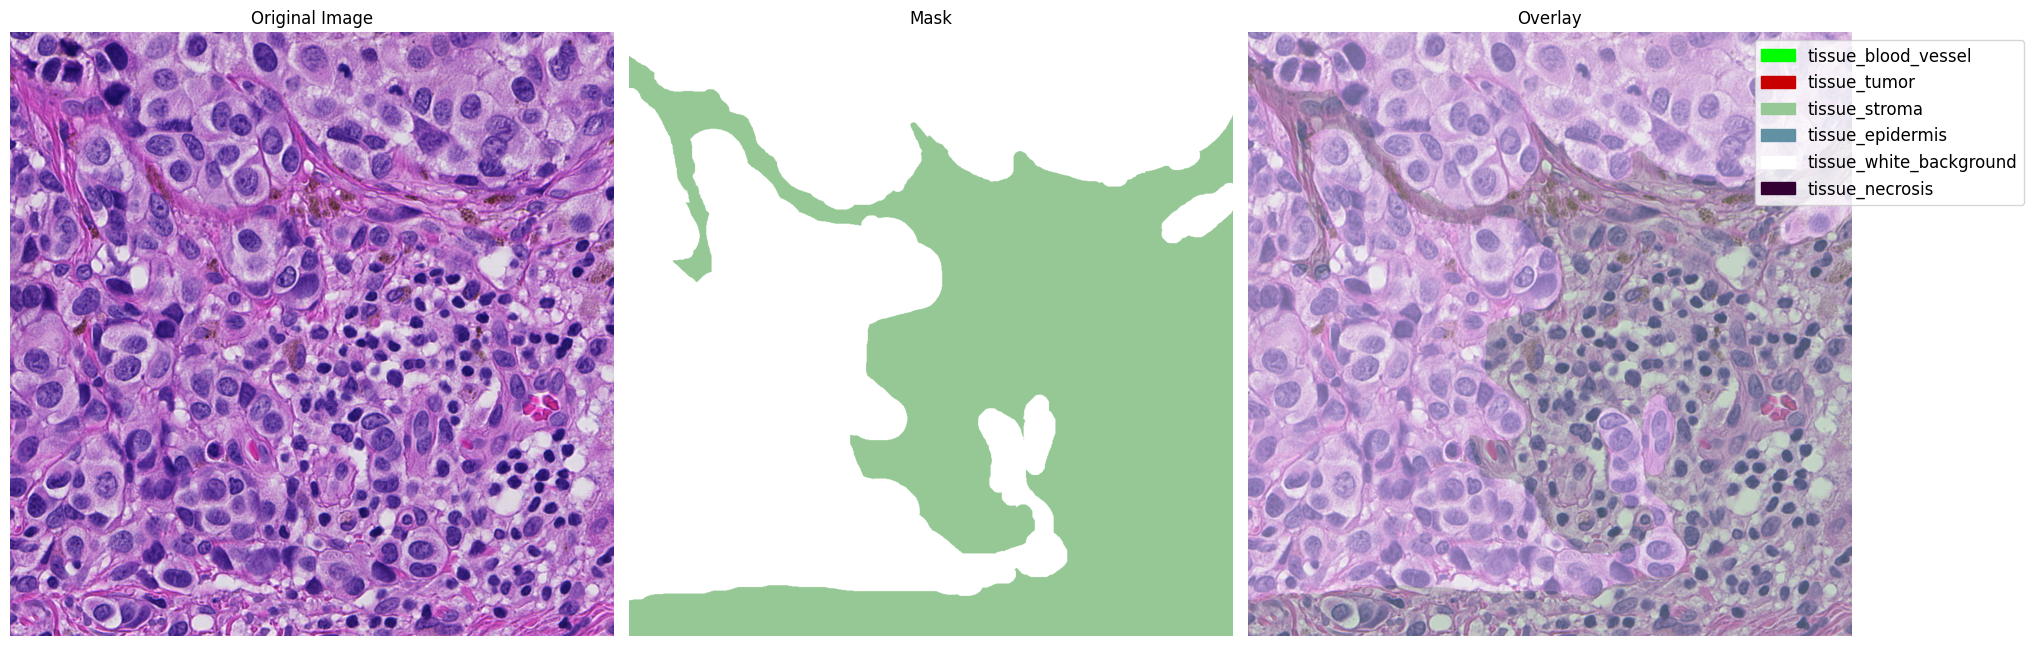

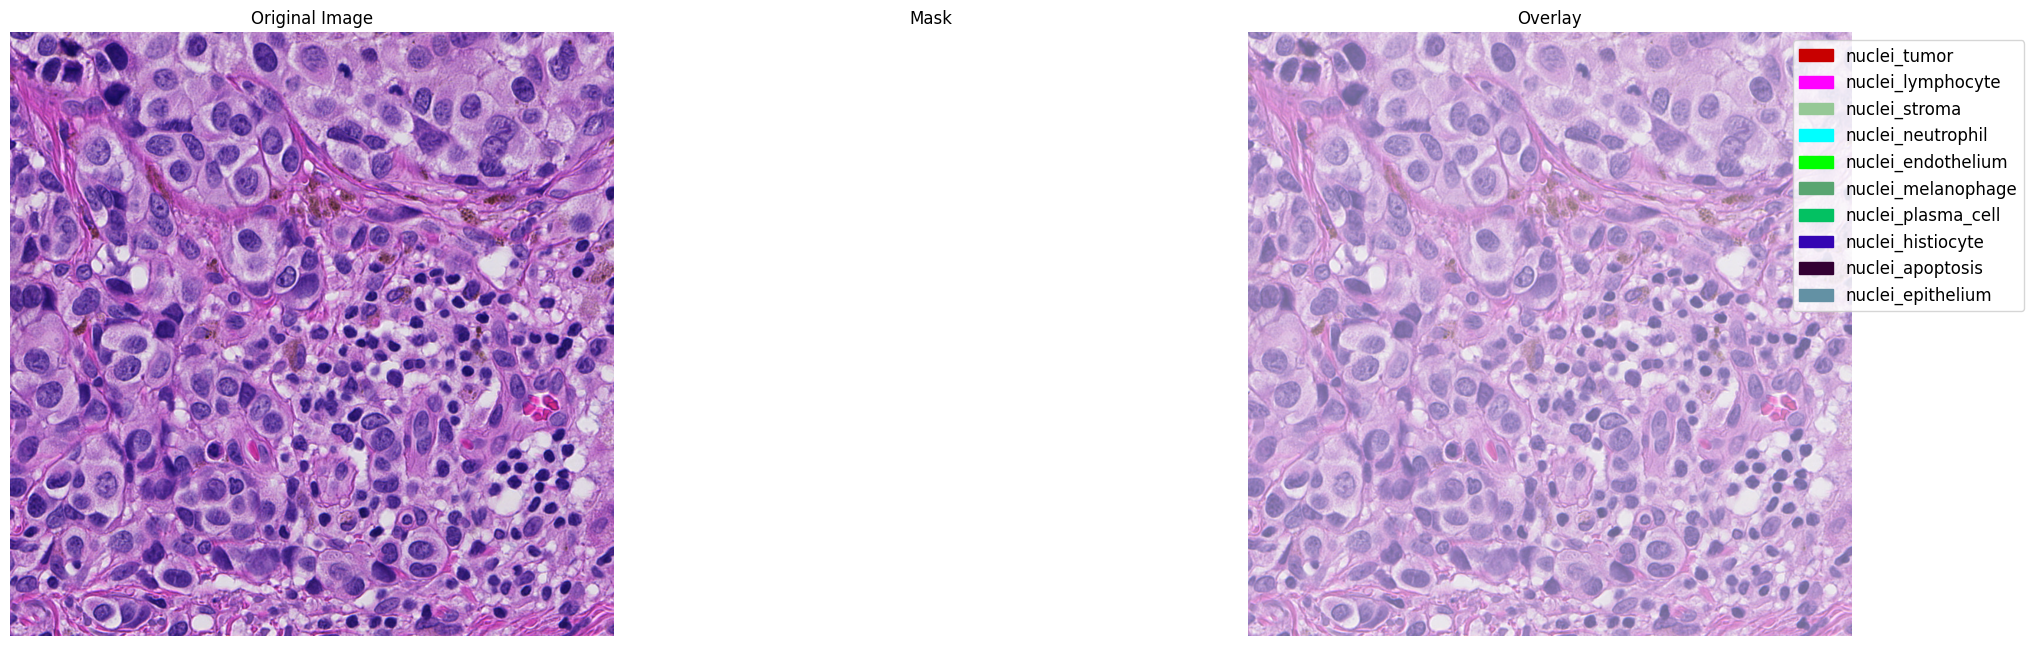

In [27]:
sammple_nr = "084"


tissue_file_path = fr"/Volumes/Samsung SSD-Bachelorarbeit/01_training_dataset_geojson_tissue/training_set_primary_roi_{sammple_nr}_tissue.geojson"
nuclei_file_path = fr'/Volumes/Samsung SSD-Bachelorarbeit/01_training_dataset_geojson_nuclei/training_set_primary_roi_{sammple_nr}_nuclei.geojson'

image_path = fr'/Volumes/Samsung SSD-Bachelorarbeit/01_training_dataset_tif_ROIs/training_set_primary_roi_{sammple_nr}.tif'


tissue_mask = create_colored_mask_from_geojson(tissue_file_path)
original_image = load_image(image_path)
tissue_overlay = create_overlay(original_image, tissue_mask)

nuclei_mask = create_colored_mask_from_geojson(nuclei_file_path)
nuclei_overlay = create_overlay(original_image, nuclei_mask)


tissue_class_colors = {
    'tissue_blood_vessel': (0, 255, 0),
    'tissue_tumor': (200, 0, 0),
    'tissue_stroma': (150, 200, 150),
    'tissue_epidermis': (99, 145, 164),
    'tissue_white_background': (255, 255, 255),
    'tissue_necrosis': (51, 0, 51)
}

nuclei_class_colors = {
    'nuclei_tumor': (200, 0, 0),
    'nuclei_lymphocyte': (255, 0, 255),
    'nuclei_stroma': (150, 200, 150),
    'nuclei_neutrophil': (0, 255, 255),
    'nuclei_endothelium': (0, 255, 0),
    'nuclei_melanophage': (89, 165, 113),
    'nuclei_plasma_cell': (3, 193, 98),
    'nuclei_histiocyte': (52, 4, 179),
    'nuclei_apoptosis': (51, 0, 51),
    'nuclei_epithelium': (99, 145, 164)
}


show_image_mask_overlay_with_inline_legend(original_image, tissue_mask, tissue_overlay, tissue_class_colors, figsize=(20, 10))
show_image_mask_overlay_with_inline_legend(original_image, nuclei_mask, nuclei_overlay, nuclei_class_colors, figsize=(20, 10))

## Get uq Class Colors 

In [125]:
import os
import json

# Funktion zum Durchsuchen eines Ordners nach GeoJSON-Dateien und Sammeln aller einzigartigen Klassen mit Farben
def extract_unique_classes_from_geojson_folder(folder_path):
    unique_classes = {}

    # Durchlaufe alle Dateien im Ordner
    for filename in os.listdir(folder_path):
        if filename.endswith('.geojson'):
            file_path = os.path.join(folder_path, filename)
            
            # GeoJSON-Datei öffnen und lesen
            with open(file_path, 'r') as file:
                geojson_data = json.load(file)
                
                # Durchlaufe alle Features in der GeoJSON-Datei
                for feature in geojson_data.get('features', []):
                    classification = feature['properties']['classification']
                    class_name = classification['name']
                    color = tuple(classification['color'])  # Farbe als Tupel speichern
                    
                    # Wenn die Klasse noch nicht in der Liste ist, hinzufügen
                    if class_name not in unique_classes:
                        unique_classes[class_name] = color

    # Ausgabe der einzigartigen Klassen und deren Farbencodings
    return unique_classes

# Beispiel: Aufruf der Funktion
folder_path = r"/Volumes/Samsung SSD-Bachelorarbeit/01_training_dataset_geojson_tissue"  # Pfad zu deiner JSON-Datei
unique_classes = extract_unique_classes_from_geojson_folder(folder_path)

# Ausgabe der Ergebnisse
for class_name, color in unique_classes.items():
    print(f"Class: {class_name}, Color: {color}")

Class: tissue_blood_vessel, Color: (0, 255, 0)
Class: tissue_tumor, Color: (200, 0, 0)
Class: tissue_stroma, Color: (150, 200, 150)
Class: tissue_epidermis, Color: (99, 145, 164)
Class: tissue_white_background, Color: (255, 255, 255)
Class: tissue_necrosis, Color: (51, 0, 51)


In [93]:
import os
import json

# Funktion zum Durchsuchen eines Ordners nach GeoJSON-Dateien und Sammeln aller einzigartigen Klassen mit Farben
def extract_unique_classes_from_geojson_folder(folder_path):
    unique_classes = {}

    # Durchlaufe alle Dateien im Ordner
    for filename in os.listdir(folder_path):
        if filename.endswith('.geojson'):
            file_path = os.path.join(folder_path, filename)
            
            # GeoJSON-Datei öffnen und lesen
            with open(file_path, 'r') as file:
                geojson_data = json.load(file)
                
                # Durchlaufe alle Features in der GeoJSON-Datei
                for feature in geojson_data.get('features', []):
                    classification = feature['properties'].get('classification', {})
                    class_name = classification.get('name')
                    color = classification.get('color')
                    
                    # Nur Klassen hinzufügen, die eine Farbe haben
                    if class_name and color:
                        color = tuple(color)  # Farbe als Tupel speichern
                        if class_name not in unique_classes:
                            unique_classes[class_name] = color

    # Rückgabe der einzigartigen Klassen und deren Farbencodings
    return unique_classes

# Hauptfunktion
if __name__ == "__main__":
    # Beispielhafter Ordnerpfad (anpassen!)
    folder_path = '/Volumes/Samsung SSD-Bachelorarbeit/01_training_dataset_geojson_nuclei' # Ordnerpfad anpassen
    
    # Aufruf der Funktion zur Extraktion der einzigartigen Klassen
    unique_classes = extract_unique_classes_from_geojson_folder(folder_path)
    
    # Ausgabe der einzigartigen Klassen und ihrer Farben
    print("Einzigartige Klassen und ihre Farbencodings:")
    for class_name, color in unique_classes.items():
        print(f"Class: {class_name}, Color: {color}")

Einzigartige Klassen und ihre Farbencodings:
Class: nuclei_tumor, Color: (200, 0, 0)
Class: nuclei_lymphocyte, Color: (255, 0, 255)
Class: nuclei_stroma, Color: (150, 200, 150)
Class: nuclei_neutrophil, Color: (0, 255, 255)
Class: nuclei_endothelium, Color: (0, 255, 0)
Class: nuclei_melanophage, Color: (89, 165, 113)
Class: nuclei_plasma_cell, Color: (3, 193, 98)
Class: nuclei_histiocyte, Color: (52, 4, 179)
Class: nuclei_apoptosis, Color: (51, 0, 51)
Class: nuclei_epithelium, Color: (99, 145, 164)


In [31]:
import os
from PIL import Image
import numpy as np

# Pfad zum Ordner mit den Bildern
image_folder = '/Volumes/Samsung SSD-Bachelorarbeit/dataset/tissue'

# Funktion zur Extraktion einzigartiger Farben aus einem Bild
def get_unique_colors(image_path):
    image = Image.open(image_path)
    image = image.convert("RGB")  # Konvertiert das Bild in den RGB-Modus
    image_array = np.array(image)
    
    # Reshape in eine 2D-Liste, sodass jede Zeile eine (R, G, B)-Farbinformation enthält
    pixels = image_array.reshape(-1, image_array.shape[-1])
    
    # Erhalte nur die einzigartigen Farben
    unique_colors = np.unique(pixels, axis=0)
    return unique_colors

# Über alle Bilder im Ordner iterieren
for filename in os.listdir(image_folder):
    if filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".jpeg"):  # Füge weitere Bildformate hinzu, falls nötig
        image_path = os.path.join(image_folder, filename)
        print(f"Verarbeite {filename}...")
        unique_colors = get_unique_colors(image_path)
        
        # Gib die RGB-Werte der einzigartigen Farben aus
        print(f"Einzigartige Farben in {filename} (RGB-Werte):")
        for color in unique_colors:
            print(f"RGB: {tuple(color)}")
        print(f"Anzahl einzigartiger Farben: {len(unique_colors)}\n")

Verarbeite training_set_metastatic_roi_059-labels.png...
Einzigartige Farben in training_set_metastatic_roi_059-labels.png (RGB-Werte):
RGB: (np.uint8(0), np.uint8(255), np.uint8(0))
RGB: (np.uint8(150), np.uint8(200), np.uint8(150))
RGB: (np.uint8(200), np.uint8(0), np.uint8(0))
RGB: (np.uint8(255), np.uint8(255), np.uint8(255))
Anzahl einzigartiger Farben: 4

Verarbeite training_set_primary_roi_097-labels.png...
Einzigartige Farben in training_set_primary_roi_097-labels.png (RGB-Werte):
RGB: (np.uint8(0), np.uint8(255), np.uint8(0))
RGB: (np.uint8(200), np.uint8(0), np.uint8(0))
Anzahl einzigartiger Farben: 2

Verarbeite training_set_primary_roi_068-labels.png...
Einzigartige Farben in training_set_primary_roi_068-labels.png (RGB-Werte):
RGB: (np.uint8(0), np.uint8(255), np.uint8(0))
RGB: (np.uint8(150), np.uint8(200), np.uint8(150))
RGB: (np.uint8(200), np.uint8(0), np.uint8(0))
Anzahl einzigartiger Farben: 3

Verarbeite training_set_metastatic_roi_091-labels.png...
Einzigartige Far

KeyboardInterrupt: 

In [2]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

def get_unique_colors_in_folder(folder_path):
    unique_colors = set()
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    for filename in tqdm(image_files, desc="Verarbeite Bilder"):
        image_path = os.path.join(folder_path, filename)
        try:
            with Image.open(image_path) as img:
                img = img.convert("RGB")  # Konvertiere das Bild in den RGB-Modus
                pixels = np.array(img)
                # Finde einzigartige Farben und füge sie der Menge hinzu
                unique_colors.update(map(tuple, pixels.reshape(-1, 3)))
        except Exception as e:
            print(f"Fehler beim Öffnen des Bildes {filename}: {e}")

    return unique_colors

# Beispiel zur Nutzung
folder_path = "../dataset/nuclei"  # Ersetze durch den Pfad zu deinem Ordner
unique_colors = get_unique_colors_in_folder(folder_path)

print(f"Anzahl einzigartiger Farben: {len(unique_colors)}")
print("Einzigartige Farben:", unique_colors)


Verarbeite Bilder: 100%|██████████████████████| 206/206 [02:49<00:00,  1.22it/s]

Anzahl einzigartiger Farben: 11
Einzigartige Farben: {(200, 0, 0), (51, 51, 51), (0, 0, 128), (0, 255, 0), (51, 0, 51), (0, 128, 128), (204, 204, 51), (255, 255, 255), (102, 26, 51), (150, 200, 150), (255, 0, 255)}


In [3]:
for i in unique_colors:
    print(i)

(200, 0, 0)
(51, 51, 51)
(0, 0, 128)
(0, 255, 0)
(51, 0, 51)
(0, 128, 128)
(204, 204, 51)
(255, 255, 255)
(102, 26, 51)
(150, 200, 150)
(255, 0, 255)
